In [1]:
import pints
import pints.toy as toy

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
from emupints.models import create_small_model, create_average_model, create_large_model

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras

import string

# Problem parameters

In [2]:
# Create a model
real_model = pints.toy.SIRModel()

n_parameters = real_model.n_parameters()
n_outputs = real_model.n_outputs()
real_parameters = np.array(real_model.suggested_parameters())
# real_parameters = np.array([0.15, 500])

values, times, noise_stds = emutils.simulate(real_model,
                                             parameters=real_parameters
                                            )

# Create an object with links to the model and time series
# or Multioutput depending on problem
if n_outputs == 1:
    problem = pints.SingleOutputProblem(real_model, times, values)
else:
    problem = pints.MultiOutputProblem(real_model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
real_log_likelihood = pints.KnownNoiseLogLikelihood(problem, noise_stds)

print("Number of parameters: ", n_parameters)
print("Parameter values: ", real_parameters)
print("Example problem values:\n", problem.values()[:5])

Number of parameters:  3
Parameter values:  [2.60e-02 2.85e-01 3.80e+01]
Example problem values:
 [[ 1.89566916 -0.94103648]
 [ 0.54681718  1.05207087]
 [ 2.67097662  0.89678512]
 [ 2.94270369  0.66014704]
 [ 3.363593   -1.0586741 ]]


In [3]:
# specify names for each parameter in the model
# default is alphabetical
index_to_param_name = dict(enumerate(string.ascii_lowercase[:n_parameters]))
index_to_param_name

{0: 'a', 1: 'b', 2: 'c'}

In [4]:
# creating distribution on bounds
# by default uniform with +-20% of original values
param_range = 0.2
real_params_lower = (1 - param_range) * real_parameters
real_params_upper = (1 + param_range) * real_parameters
#real_params_lower = [0.1, 400]
#real_params_upper = [0.2, 600]
bounds = pints.RectangularBoundaries(lower = real_params_lower, upper = real_params_upper)
log_prior = pints.UniformLogPrior(bounds)

print(list(zip(bounds.lower(), bounds.upper())))

[(0.0208, 0.0312), (0.22799999999999998, 0.34199999999999997), (30.400000000000002, 45.6)]


In [5]:
# scoring function for CMA-ES and comparison
score = pints.SumOfSquaresError(problem)

# Toy problems contour graphs

Use to get an idea of continuity for high-dimensional inputs

In [6]:
fixed_parameters = emutils.fix_parameters(bounds)

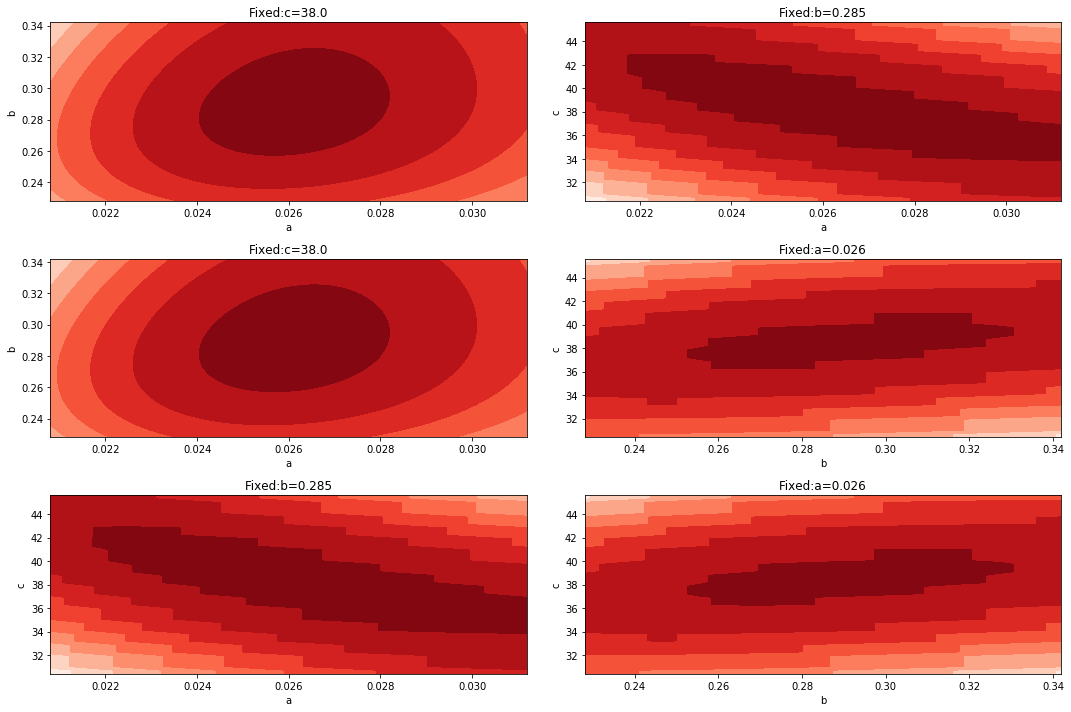

In [7]:
# row i has parameter i varying with every other parameter in the model
# however, x-axis is always taken by parameter that comes first in order
# i.e. lower index

if n_parameters > 2:  
    fig, ax = emuplt.plot_fixed_param_grid(
        real_log_likelihood,
        fixed_parameters,
        bounds,
        n_splits = 50, # number of splits on each free parameter
        shape = (n_parameters, n_parameters - 1),
    )

    plt.show(fig)

# Create dataset for training

In [8]:
# training size
training_size = 5000
test_size = 100

train_data = log_prior.sample(training_size)
train_target = np.apply_along_axis(real_log_likelihood, 1, train_data)

test_data = log_prior.sample(training_size)
test_target = np.apply_along_axis(real_log_likelihood, 1, test_data)

In [9]:
# normalize using standardisation for inputs

train_data_mean = np.mean(train_data, axis=0)
train_data_std = np.std(train_data, axis=0)

train_data_normalized = (train_data - train_data_mean) / train_data_std

# normalise test using same mean and var as train
test_data_normalized = (test_data - train_data_mean) / train_data_std


def normalize_input(x):
    return (x - train_data_mean) / train_data_std

# normalise target between [-1, 1]

train_target_min = np.min(train_target, axis = 0)
train_target_max = np.max(train_target, axis = 0)

train_target_normalized = 2 * (train_target - train_target_min) / (train_target_max - train_target_min) - 1
test_target_normalized = 2 * (test_target - train_target_min) / (train_target_max - train_target_min) - 1

def denormalize_prediction(x_norm):
    return (x_norm + 1) * (train_target_max - train_target_min) / 2 + train_target_min


# normalize data between [-1, 1] for output

# Create NN

In [10]:
# Hyperparameters
EPOCHS = 100
BATCH = 32
# learning_rate = 0.01

In [11]:
model = create_large_model(n_parameters)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 66,561
Trainable params: 66,561
Non-trainable params: 0
_________________________________________________________________


In [12]:
# use early stopping?
es_callback = keras.callbacks.EarlyStopping(monitor='mae')

In [13]:
#optimizer = tf.train.RMSPropOptimizer(learning_rate)

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'] # mean absolute error
             )

In [14]:
history = model.fit(train_data_normalized, 
                    train_target_normalized, 
                    epochs=EPOCHS,
                    batch_size = BATCH,
                    validation_split=0.2,
                   )

Train on 4000 samples, validate on 1000 samples
Epoch 1/100
4000/4000 [==============================] - 1s 136us/step - loss: 0.0587 - mean_absolute_error: 0.1658 - val_loss: 0.0053 - val_mean_absolute_error: 0.0530
Epoch 2/100
4000/4000 [==============================] - 0s 78us/step - loss: 0.0040 - mean_absolute_error: 0.0472 - val_loss: 0.0031 - val_mean_absolute_error: 0.0396
Epoch 3/100
4000/4000 [==============================] - 0s 62us/step - loss: 0.0029 - mean_absolute_error: 0.0398 - val_loss: 0.0029 - val_mean_absolute_error: 0.0369
Epoch 4/100
4000/4000 [==============================] - 0s 70us/step - loss: 0.0021 - mean_absolute_error: 0.0339 - val_loss: 0.0015 - val_mean_absolute_error: 0.0280
Epoch 5/100
4000/4000 [==============================] - 0s 89us/step - loss: 0.0023 - mean_absolute_error: 0.0357 - val_loss: 0.0040 - val_mean_absolute_error: 0.0444
Epoch 6/100
4000/4000 [==============================] - 0s 75us/step - loss: 0.0020 - mean_absolute_error: 0.0

4000/4000 [==============================] - 0s 56us/step - loss: 0.0014 - mean_absolute_error: 0.0278 - val_loss: 0.0014 - val_mean_absolute_error: 0.0270
Epoch 50/100
4000/4000 [==============================] - 0s 70us/step - loss: 0.0015 - mean_absolute_error: 0.0281 - val_loss: 0.0014 - val_mean_absolute_error: 0.0268
Epoch 51/100
4000/4000 [==============================] - 0s 110us/step - loss: 0.0013 - mean_absolute_error: 0.0267 - val_loss: 0.0013 - val_mean_absolute_error: 0.0267
Epoch 52/100
4000/4000 [==============================] - 0s 45us/step - loss: 0.0015 - mean_absolute_error: 0.0277 - val_loss: 0.0013 - val_mean_absolute_error: 0.0261
Epoch 53/100
4000/4000 [==============================] - 1s 150us/step - loss: 0.0013 - mean_absolute_error: 0.0261 - val_loss: 0.0013 - val_mean_absolute_error: 0.0264
Epoch 54/100
4000/4000 [==============================] - 0s 47us/step - loss: 0.0016 - mean_absolute_error: 0.0291 - val_loss: 0.0015 - val_mean_absolute_error: 0.02

4000/4000 [==============================] - 0s 40us/step - loss: 0.0014 - mean_absolute_error: 0.0271 - val_loss: 0.0014 - val_mean_absolute_error: 0.0264
Epoch 98/100
4000/4000 [==============================] - 0s 46us/step - loss: 0.0013 - mean_absolute_error: 0.0258 - val_loss: 0.0012 - val_mean_absolute_error: 0.0248
Epoch 99/100
4000/4000 [==============================] - 0s 49us/step - loss: 0.0012 - mean_absolute_error: 0.0256 - val_loss: 0.0012 - val_mean_absolute_error: 0.0250
Epoch 100/100
4000/4000 [==============================] - 0s 93us/step - loss: 0.0013 - mean_absolute_error: 0.0266 - val_loss: 0.0015 - val_mean_absolute_error: 0.0271


In [15]:
model.predict(normalize_input([real_parameters]))

array([[0.973036]], dtype=float32)

In [16]:
loss, mae = model.evaluate(test_data_normalized, test_target_normalized)
print("Model loss: {:.10f}".format(loss))
print("Mean absolute error: {:.10f}".format(mae))

5000/5000 [==============================] - 0s 47us/step
Model loss: 0.0015120311
Mean absolute error: 0.0281565853


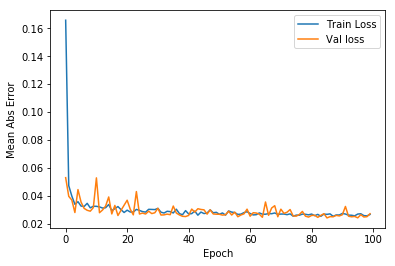

In [17]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
       label='Train Loss')
plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
       label = 'Val loss')
plt.legend()

In [18]:
# calculate not normalized mean absolute error for test
test_prediction = denormalize_prediction(model.predict(test_data_normalized))
diff = np.mean(np.abs(test_prediction - train_target))
diff

399.04398306198397

# Plotting model

In [19]:
# create a callable object
# need to preprocess inputs and output
def emu(x):
    return denormalize_prediction(model.predict(normalize_input(np.array([x]))))

In [20]:
emu = emupints.EmulatorWrapper(emu, n_parameters)

In [21]:
if n_parameters == 2:
    # generate data for surfaces
    test_splits = 20 # number of splits along each axis
    r_grid, k_grid, test_data = emutils.generate_grid(bounds.lower(), 
                                                      bounds.upper(), 
                                                      test_splits)    

    emu_grid = emutils.predict_grid(emu, test_data)
    real_grid = emutils.predict_grid(real_log_likelihood, test_data)

    plt.figure(figsize = (10, 5))
    ax = emuplt.surface(r_grid, k_grid, emu_grid, 
                        title = "True log_likelihood",
                        alpha = 0.8,
                        cmap="Blues",
                        x_label = "r (growth rate)",
                        y_label = "k (carrying capacity)"
                       )

    ax.plot_surface(r_grid, k_grid, real_grid, cmap="Reds", alpha = .5)

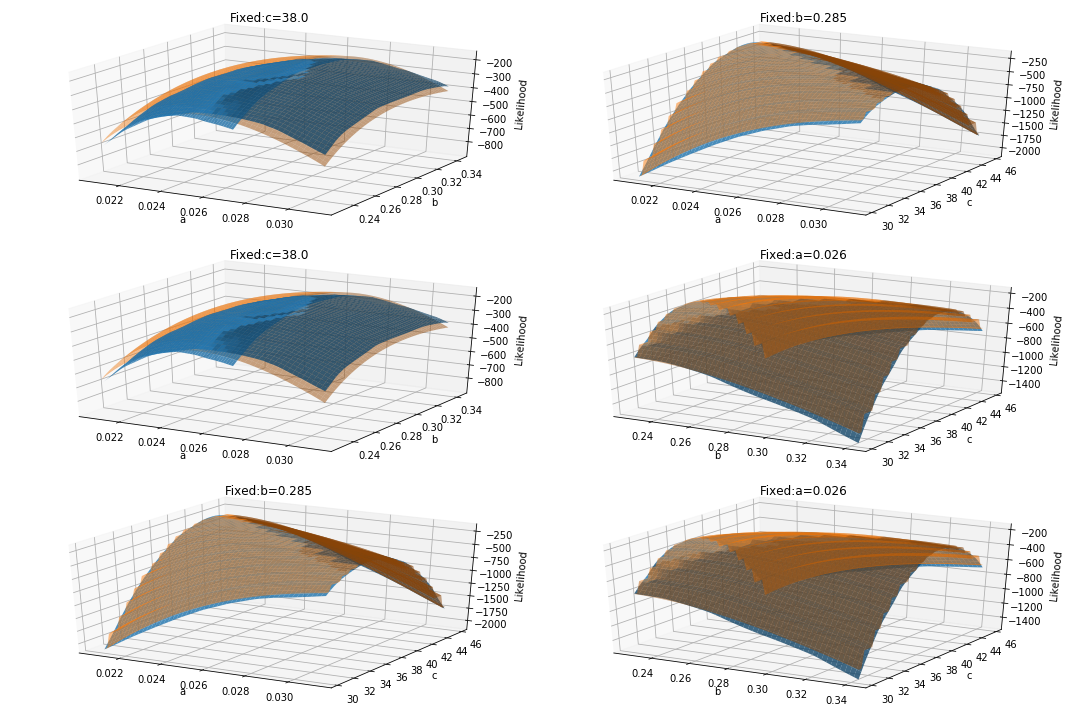

In [22]:
if n_parameters >=3:
    fig, ax = emuplt.plot_fixed_param_grid(
        emu,
        fixed_parameters,
        bounds,
        n_splits = 50,
        shape = (n_parameters, n_parameters - 1),
        countour = False,
        additional_log_likelihoods = [real_log_likelihood]
    )

    plt.show(fig)
    
# for row i we have parameter i fixed and some other parameter j, depending on the column, j != i

# Timing single prediction

In [23]:
%%timeit
emu(real_parameters)

376 µs ± 55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%%timeit
real_log_likelihood(real_parameters)

578 µs ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Comparing MCMC run times

In [25]:
# for Logistic and Lotka-Voltera use default
mcmc_method = None
# mcmc_method = pints.PopulationMCMC
# mcmc_method = pints.AdaptiveCovarianceMCMC
# mcmc_method = pints.DifferentialEvolutionMCMC


# MCMC parameters
num_chains = 3
max_iters = 10000

In [26]:
# Create a posterior log-likelihood (log(likelihood * prior))
emu_posterior = pints.LogPosterior(emu, log_prior)
real_posterior = pints.LogPosterior(real_log_likelihood, log_prior)

In [27]:
# returns some possible initial parameter values
# normal noise with 
def guess_params():
    return real_parameters * (1 + np.random.normal(scale=0.05))

In [28]:
x0 = guess_params()
# x0 = [0.17, 420]

In [29]:
# CMA-es
found_parameters, found_value = pints.optimise(
    score,
    x0,
    None,
    bounds,
    method=pints.CMAES
)

Minimising error measure
using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      603.7669   0:00.1
1     14     483.8151   0:00.1
2     21     298.8453   0:00.1
3     28     298.1917   0:00.1
20    147    297.7689   0:00.2
40    287    297.767    0:00.3
60    427    297.767    0:00.4
80    567    297.767    0:00.5
100   707    297.767    0:00.6
120   847    297.767    0:00.7
140   987    297.767    0:00.8
160   1127   297.767    0:00.9
180   1267   297.767    0:01.0
200   1407   297.767    0:01.1
220   1547   297.767    0:01.2
240   1687   297.767    0:01.3
260   1827   297.767    0:01.4
263   1841   297.767    0:01.5
Halting: No significant change for 200 iterations.


In [30]:
print(found_value)
print(found_parameters)

297.76697301605407
[2.97776412e-02 2.71480034e-01 3.56080150e+01]


In [31]:
xs = [
    found_parameters,
    found_parameters * 1.01,
    found_parameters * 0.99
]
xs

[array([2.97776412e-02, 2.71480034e-01, 3.56080150e+01]),
 array([3.00754176e-02, 2.74194834e-01, 3.59640952e+01]),
 array([2.94798648e-02, 2.68765233e-01, 3.52519349e+01])]

In [32]:
%%time
emu_mcmc = pints.MCMCSampling(emu_posterior,
                              num_chains,
                              xs,
                              method = mcmc_method,
                             )
emu_mcmc.set_log_to_screen(False)
print('Running...')
emu_chains = emu_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 21.6 s, sys: 2.56 s, total: 24.1 s
Wall time: 19.9 s


In [33]:
%%time
# population MCMC
real_mcmc = pints.MCMCSampling(real_posterior, 
                               num_chains, 
                               xs, 
                               method = mcmc_method,
                               )
real_mcmc.set_max_iterations(max_iters)
real_mcmc.set_log_to_screen(False)
# Run!
print('Running...')
real_chains = real_mcmc.run()
print('Done!')

Running...
Done!
CPU times: user 21.2 s, sys: 83.2 ms, total: 21.3 s
Wall time: 21.3 s


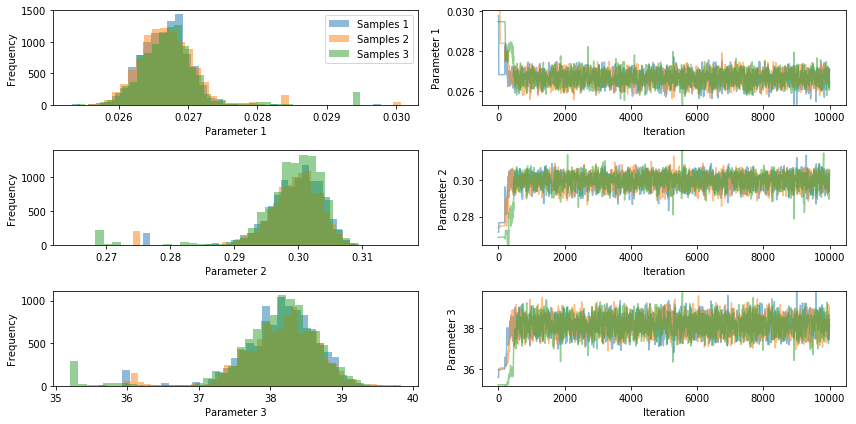

In [34]:
import pints.plot
pints.plot.trace(emu_chains)
plt.show()

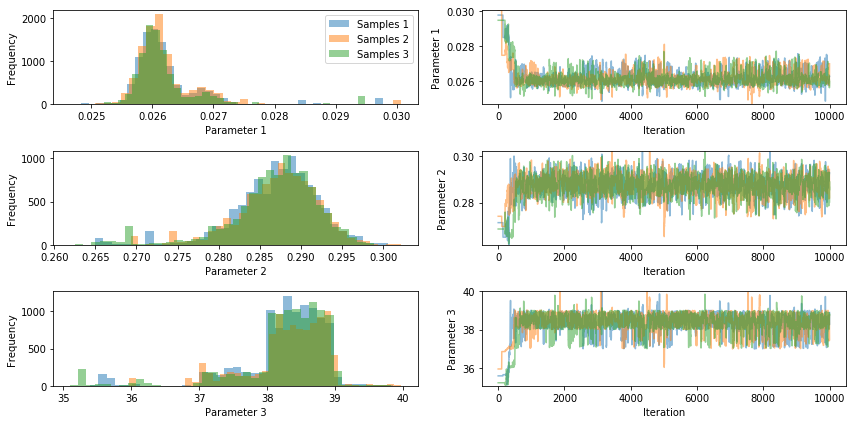

In [35]:
pints.plot.trace(real_chains)
plt.show()

In [36]:
chain = real_chains[0]

emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
real_prediction = np.apply_along_axis(real_log_likelihood, 1, chain).flatten()

diffs = np.abs(real_prediction - emu_prediction)

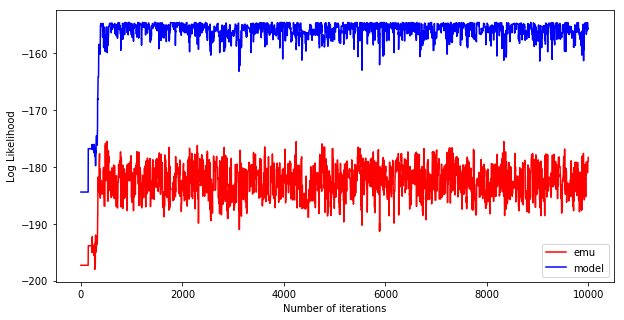

In [37]:
iters = range(len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Log Likelihood")
plt.plot(iters, emu_prediction, color="Red", label='emu')
plt.plot(iters, real_prediction, color="Blue", label='model')
plt.legend()
plt.show()

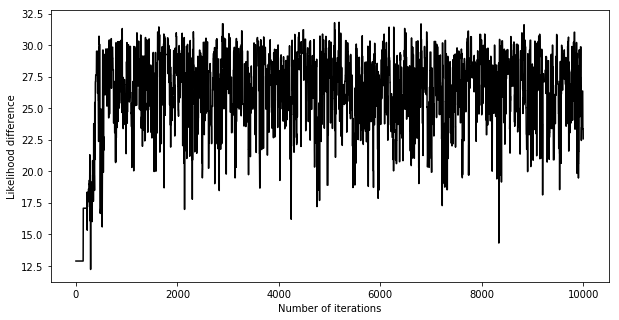

In [38]:
iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood difference")
plt.plot(iters, diffs, color = "Black")
plt.show()